In [202]:
import networkx as nx
from scipy.io import loadmat
from scipy.linalg import eigh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## a) Construct a network from the flight data

In [5]:
node_metadata = pd.read_csv('data/epidemics/airport_Nodes_GC.csv')
edge_data = pd.read_csv('data/epidemics/airport_Edges_GC.csv')

node_id_map = {given_id: node_id for (given_id, node_id) in zip(node_metadata.Id, node_metadata.index)}

In [257]:
A_dir = np.zeros((len(node_id_map), len(node_id_map)))

# build directed adjacency matrix from edge data
for i, row in edge_data.iterrows():
    u, v = node_id_map[row.Source], node_id_map[row.Target]
    A_dir[u][v] = row.Weight

# Compute undirected A
A = (A_dir + A_dir.T) / 2
G = nx.from_numpy_matrix(A)

In [260]:
# confirm graph is connected
print(A.shape[0], len(G.nodes()))
print('Graph is connected: {}'.format(nx.is_connected(G)))

2905 2905
Graph is connected: True


## b) Plot the airport network

In [255]:
# Compute eigenvector centrality of each node
evec_centralities = nx.centrality.eigenvector_centrality(G, weight='weight')

In [256]:
'Top 2 e-vec centralities: {}'.format(list(sorted(evec_centralities.values()))[-2:])

'Top 2 e-vec centralities: [0.16991022532548966, 0.1785292296913075]'

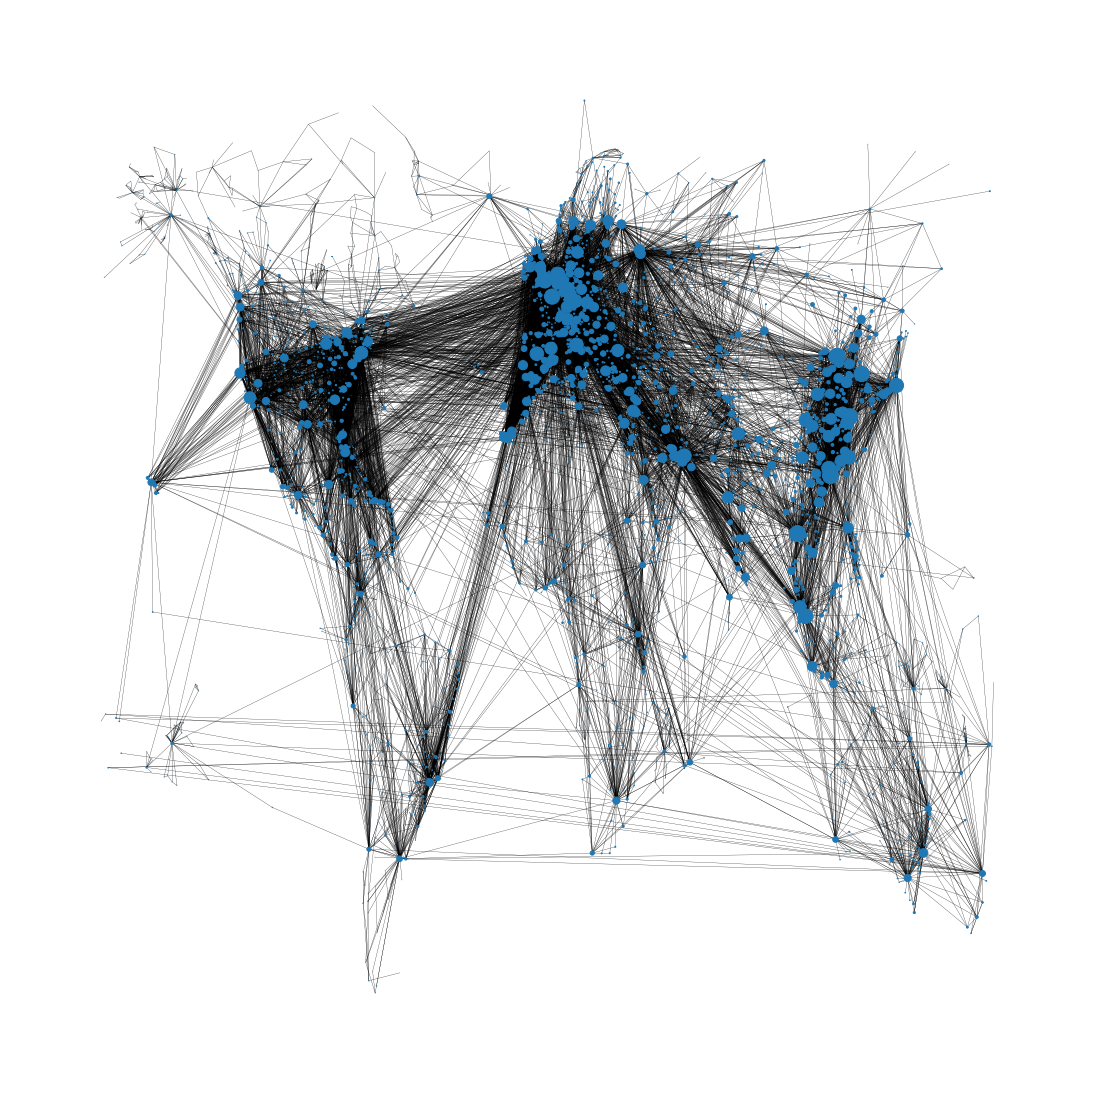

In [258]:
# plot the network, using lat/long as node locations and e-vector centrality as node sizes
pos = {idx: (row.Longitude, row.Latitude) for idx, row in node_metadata.iterrows()}
node_size = [evec_centralities[n] * 1500 for n in G.nodes()]
plt.figure(1, figsize=(15, 15))
nx.draw(G, pos=pos, node_size=node_size, width=0.25)

## d) Mean-field approximation

In [261]:
def dp_dt(A, p_t, beta, gamma):
    left = beta * (1 - p_t)
    right = (A @ p_t) - (gamma * p_t)
    return left * right

In [280]:
def infect(A, beta, gamma, dp_dt):
    # infect the first 20 nodes
    p_0 = np.zeros((len(A),))
    p_0[:20] = 1

    # compute infection probabilities over time
    t_max = 5
    delta = 0.05

    P = np.zeros((len(p_0), int(t_max / delta)))
    P[:, 0] = p_0

    for i in range(1, int(t_max / delta)):
        P[:, i] = P[:, i-1] + (delta * dp_dt(A, P[:, i-1], beta, gamma))

    return P


Text(0, 0.5, 'Expected infection size')

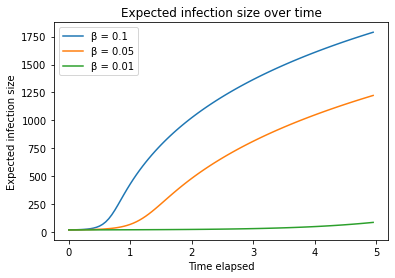

In [293]:
gamma = 0.1

P_bar_all = []
for beta in (0.1, 0.05, 0.01):
    P = infect(A, beta, 0.1, dp_dt)
    P_bar_all.append(P.sum(axis=0))

x = np.array(range(0, int(5 / 0.05))) * 0.05
[plt.plot(x, P_bar) for P_bar in P_bar_all]
plt.legend(["β = 0.1", "β = 0.05", "β = 0.01"])
plt.title("Expected infection size over time")
plt.xlabel("Time elapsed")
plt.ylabel("Expected infection size")

## e) Minimum number of immunizations

In [294]:
# compute required threshold for λ_max(A)
beta = 0.01
gamma = 0.4

'Must have λ_max(A) < {}'.format(gamma / beta)

'Must have λ_max(A) < 40.0'

In [290]:
def immunize(A, node_order, eval_thresh, start_at=0):
    A_imm = A.copy()

    for i in range(len(node_order)):    
        # remove a node
        n = node_order[i]

        # setting to 0 creates additional e-vals that are 0, but doesn't change the max e-val
        #   this is easier than deleting rows/columns
        A_imm[n, :] = 0
        A_imm[:, n] = 0

        if i < start_at:
            continue
        elif i == start_at:
            print('Starting with {} nodes removed'.format(i))

        # recompute max e-val
        w_max = eigh(A_imm, eigvals_only=True, eigvals=(len(A_imm) - 1, len(A_imm) - 1))[0]

        if w_max < eval_thresh:
            print('Max e-val after removing {} nodes: {}'.format(i+1, w_max))
            break

        if i % 5 == 4:  
            print('Max e-val after removing {} nodes: {}'.format(i+1, w_max))
    
    return A_imm

In [291]:
# compute degree centrality
degree_centralities = A.sum(axis=1) / (len(A) - 1)

# order nodes by degree centrality
node_order = np.argsort(degree_centralities)[::-1]

# compute number of nodes necessary to remove
immunize(A, node_order, gamma / beta, start_at=65); # start with 65 to speed up re-computation

Starting with 65 nodes removed
Max e-val after removing 70 nodes: 41.151565542207784
Max e-val after removing 73 nodes: 37.41654106581537


In [292]:
# compute e-val centrality
eval_centralities_dict = nx.centrality.eigenvector_centrality(G, weight='weight')
eval_centralities = np.array([eval_centralities_dict[n] for n in G.nodes()])

# order nodes by e-val centrality
node_order = np.argsort(eval_centralities)[::-1]

# compute number of nodes necessary to remove
immunize(A, node_order, gamma / beta, start_at=120);

Starting with 120 nodes removed
Max e-val after removing 125 nodes: 39.427119599712015


 Degree centrality only required 73 nodes to be removed, while e-val centrality required 125 nodes to be removed.